# Steal Now and Attack Later

This notebook provides a demonstration showing how to use ART to launch the SNAL attack [1].

The core concept of this attack is to first collect objects from any model and then in a second step append valid patches to the target image and weaken the impact of unimportant pixels.


[1] Steal Now and Attack Later: Evaluating Robustness of Object Detection against Black-box Adversarial Attacks (https://arxiv.org/abs/2404.15881)

In [1]:
import logging
import sys

import numpy as np
import torch

logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)
logger.addHandler(logging.StreamHandler(sys.stdout))

In [2]:
#%% Download a target image from MS COCO dataset
from io import BytesIO
from PIL import Image

import requests
TARGET = 'https://farm2.staticflickr.com/1065/705706084_39a7f28fc9_z.jpg' # val2017/000000552842.jpg
response = requests.get(TARGET)
org_img = np.asarray(Image.open(BytesIO(response.content)).resize((640, 640)))
org_x = np.stack([org_img.transpose((2, 0, 1))], axis=0).astype(np.float32)

In [3]:
#%% Download YOLOv8 model
# If ultralytics is not found, please run the command: `pip install ultralytics`
from ultralytics import YOLO
from art.estimators.object_detection import PyTorchYolo

model = YOLO('yolov8m')
py_model = PyTorchYolo(model=model,
                       input_shape=(3, 640, 640),
                       channels_first=True)

# Define a custom function to collect patches from images
def collect_patches_from_images(model: "torch.nn.Module",
                                imgs: "torch.Tensor"):
    """
    Collect patches and corrsponding spatial information by the model from images.

    :param model: Object detection model.
    :param imgs: Target images.

    :return: Detected objects and corrsponding spatial information.
    """
    import torch

    bs = imgs.shape[0]
    with torch.no_grad():
        pred = model.model(imgs)
    y = []
    for obj in pred:
        y.append(obj.boxes.xyxy)

    candidates_patch = []
    candidates_position = []
    for i in range(bs):
        patch = []
        if y[i].shape[0] == 0:
            candidates_patch.append(patch)
            candidates_position.append(torch.zeros((0, 4), device=model.device))
            continue

        pos_matrix = y[i][:, :4].clone().int()
        pos_matrix[:, 0] = torch.clamp_min(pos_matrix[:, 0], 0)
        pos_matrix[:, 1] = torch.clamp_min(pos_matrix[:, 1], 0)
        pos_matrix[:, 2] = torch.clamp_max(pos_matrix[:, 2], imgs.shape[3])
        pos_matrix[:, 3] = torch.clamp_max(pos_matrix[:, 3], imgs.shape[2])
        for e in pos_matrix:
            p = imgs[i, :, e[1]:e[3], e[0]:e[2]]
            patch.append(p.to(model.device))

        candidates_patch.append(patch)
        candidates_position.append(pos_matrix)

    return candidates_patch, candidates_position

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#%% Prepare dataset
import os
import time

# Select images randomly from COCO dataset
list_url = ['http://farm4.staticflickr.com/3572/5744200926_082c11c43c_z.jpg', #000000460229
            'http://farm4.staticflickr.com/3010/2749181045_ed450e5d36_z.jpg', #000000057760
            'http://farm4.staticflickr.com/3826/9451771633_f14cef3a8b_z.jpg', #000000468332
            'http://farm7.staticflickr.com/6194/6106161903_e505cbc192_z.jpg', #000000190841
            'http://farm1.staticflickr.com/48/140268688_947e2bcc96_z.jpg',    #000000078420
            'http://farm6.staticflickr.com/5011/5389083366_fdf13f2ee6_z.jpg', #000000309655
            'http://farm4.staticflickr.com/3552/5812461870_eb24c8eac5_z.jpg', #000000293324
            'http://farm4.staticflickr.com/3610/3361019695_1005dd49fd_z.jpg', #000000473821
            'http://farm8.staticflickr.com/7323/9725958435_3359641442_z.jpg', #000000025386
            'http://farm4.staticflickr.com/3317/3427794620_9db24fe462_z.jpg', #000000347693
            'http://farm6.staticflickr.com/5143/5589997131_22f51b308c_z.jpg', #000000058029
            'http://farm5.staticflickr.com/4061/4376326145_7ef66603e3_z.jpg', #000000389933
            'http://farm3.staticflickr.com/2028/2188480725_5fbf27a5b3_z.jpg', #000000311789
            'http://farm1.staticflickr.com/172/421715600_666b0f6a2b_z.jpg',   #000000506004
            'http://farm1.staticflickr.com/168/473782444_8ec11ec7b3_z.jpg',   #000000203317
            'http://farm4.staticflickr.com/3236/2487649513_1ef6a6d5c9_z.jpg', #000000201646
            'http://farm4.staticflickr.com/3094/2684280938_a5b59c0fac_z.jpg', #000000447187
            'http://farm1.staticflickr.com/42/100911501_005e4d3aa8_z.jpg',    #000000126107
            'http://farm1.staticflickr.com/56/147795701_40d7bc8331_z.jpg',    #000000505942
            'http://farm5.staticflickr.com/4103/5074895283_71a73d77e5_z.jpg', #000000360951
            'http://farm1.staticflickr.com/160/404335548_3bdc1f2ed9_z.jpg',   #000000489764
            'http://farm9.staticflickr.com/8446/7857456044_401a257790_z.jpg', #000000407574
 ]

ROOT_MSCOCO = 'datasets'
os.makedirs(ROOT_MSCOCO, exist_ok = True)
for idx, img_url in enumerate(list_url):
    response = requests.get(img_url)
    with open(f'{ROOT_MSCOCO}/{idx:03d}.jpg', 'wb') as f:
        f.write(response.content)
    time.sleep(0.5)

In [5]:
#%% Collect patches
import glob
from torchvision import transforms
from torchvision.datasets.vision import VisionDataset

class CustomDatasetFolder(VisionDataset):
    def __init__(self, root, transform=None):
        super(CustomDatasetFolder, self).__init__(root)
        self.transform = transform
        samples = glob.glob(f"{root}/*.jpg")

        self.samples = samples

    def __getitem__(self, index):
        sample = self._loader(self.samples[index])
        if self.transform is not None:
            sample = self.transform(sample)
        return sample
    
    def __len__(self):
        return len(self.samples)

    def _loader(self, path):
        return Image.open(path).convert("RGB")

img_dataset = CustomDatasetFolder(
            ROOT_MSCOCO,
            transforms.Compose([
            transforms.RandomResizedCrop((640,640)),
            transforms.AutoAugment(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]))
img_loader = torch.utils.data.DataLoader(img_dataset, batch_size=1, shuffle=True)

candidates_list = []
TILE_SIZE = 64
MAX_IMGS = 25
img_count = 0
for x in iter(img_loader):
    img_count = img_count + 1
    if img_count == MAX_IMGS:
        break

    candidates, _ = collect_patches_from_images(py_model, x.to(py_model.device))
    print(f'Number of objects are detected: {len(candidates[0])}')
    candidates_list = candidates_list + candidates[0]

print(len(candidates_list))


0: 640x640 (no detections), 478.6ms
Speed: 0.0ms preprocess, 478.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)
Number of objects are detected: 0

0: 640x640 1 bicycle, 307.1ms
Speed: 0.0ms preprocess, 307.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)
Number of objects are detected: 1

0: 640x640 1 cat, 343.0ms
Speed: 0.0ms preprocess, 343.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)
Number of objects are detected: 1

0: 640x640 1 traffic light, 1 bench, 317.9ms
Speed: 0.0ms preprocess, 317.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)
Number of objects are detected: 2

0: 640x640 1 teddy bear, 331.0ms
Speed: 0.0ms preprocess, 331.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)
Number of objects are detected: 1

0: 640x640 1 bicycle, 1 skis, 297.9ms
Speed: 0.0ms preprocess, 297.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Number of objects are detect

In [6]:
#%% Apply attack
from art.attacks.evasion import SNAL
attack = SNAL(py_model,
              eps = 16.0 /255.0,
              max_iter = 100,
              num_grid = 10,
              candidates=candidates_list,
              collector=collect_patches_from_images)
x_adv = (attack.generate(org_x / 255.0) * 255.0)
adv_np = np.transpose(x_adv[0, :], (1, 2, 0)).astype(np.uint8)
Image.fromarray(adv_np).save(f'output.png')
Image.fromarray(org_img).save(f'target.png')

# Visualize the results
from IPython.display import Image as PyImage
results = model(['target.png', 'output.png'])


0: 640x640 14 persons, 2 bicycles, 1 bottle, 355.1ms
1: 640x640 11 persons, 2 bicycles, 1 airplane, 1 bus, 1 horse, 1 cow, 1 bottle, 355.1ms
2: 640x640 10 persons, 1 train, 1 baseball bat, 1 bottle, 1 laptop, 355.1ms
3: 640x640 4 persons, 2 bicycles, 3 cars, 1 airplane, 1 horse, 1 skateboard, 1 laptop, 1 keyboard, 1 clock, 1 vase, 355.1ms
4: 640x640 14 persons, 4 bicycles, 1 airplane, 1 horse, 1 laptop, 355.1ms
5: 640x640 12 persons, 1 car, 2 trains, 1 horse, 1 keyboard, 355.1ms
6: 640x640 14 persons, 2 bicycles, 1 traffic light, 1 cow, 1 skateboard, 1 remote, 355.1ms
7: 640x640 9 persons, 1 bicycle, 1 airplane, 1 cow, 1 suitcase, 355.1ms
8: 640x640 10 persons, 2 bicycles, 2 airplanes, 1 clock, 355.1ms
9: 640x640 9 persons, 1 bicycle, 1 cow, 1 wine glass, 355.1ms
Speed: 0.0ms preprocess, 355.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 persons, 1 truck, 1 apple, 8 chairs, 2 clocks, 314.9ms
1: 640x640 5 persons, 1 suitcase, 1 baseball bat, 1 baseb

3


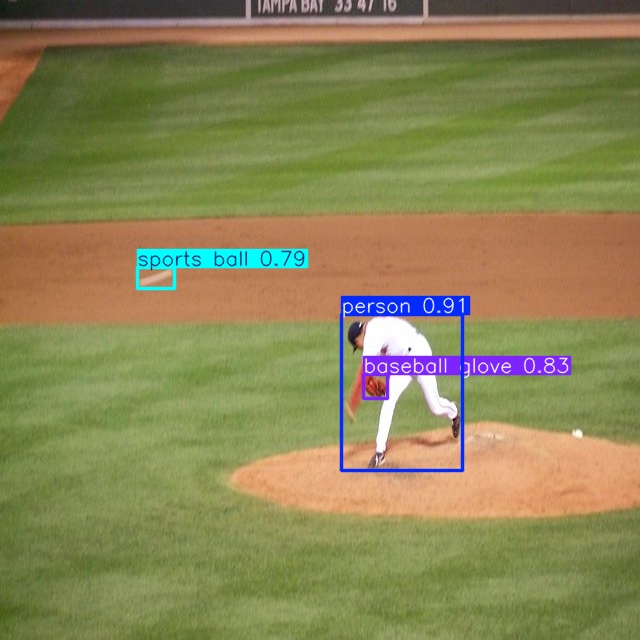

In [7]:
results[0].save("results.jpg")
logger.info(len(results[0].boxes.xyxy))
PyImage(filename=f"results.jpg")

78


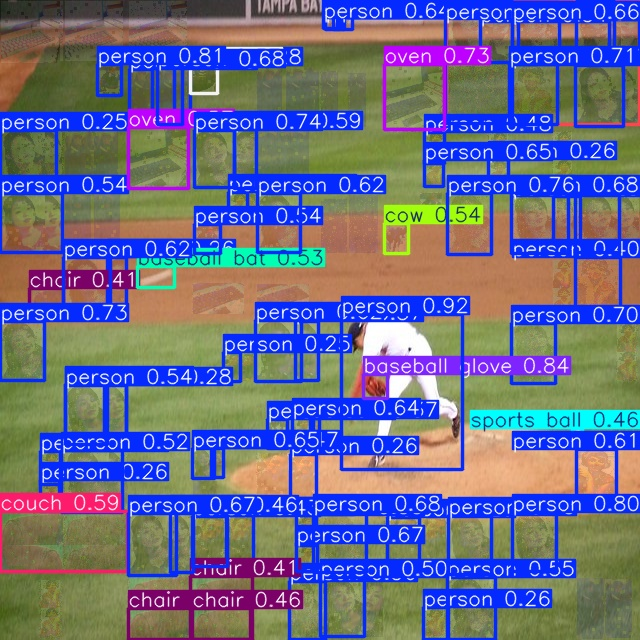

In [8]:
results[1].save("results.jpg")
logger.info(len(results[1].boxes.xyxy))
PyImage(filename=f"results.jpg")